In [1]:
!date

Fri Oct 23 08:31:02 PDT 2020


# Compare good vs bad GENE level quantification

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [4]:
good = pd.read_csv("../../tables/unordered/union_test_subclass_DE.csv", index_col=0)
bad  = pd.read_csv("../../tables/unordered/union_test_subclass_DE_bad.csv", index_col=0)

In [6]:
gene_good = anndata.read_h5ad("../../data/notebook/revision/no_filter_gene.h5ad")
gene_bad  = anndata.read_h5ad("../../data/notebook/revision/bad_gene.h5ad")

In [7]:
good.groupby("index")['gene_name'].count()

index
Astro             0
Endo             52
L2/3 IT        3611
L5 IT          3349
L5 PT           289
L5/6 NP        1096
L6 CT          1960
L6 IT          2268
L6 IT Car3       17
L6b            2748
Lamp5           627
Low Quality      74
Pvalb          1466
SMC              72
Sncg            613
Sst             848
VLMC              8
Vip             375
Name: gene_name, dtype: int64

In [8]:
bad.groupby("index")['gene_name'].count()

index
Astro             0
Endo             52
L2/3 IT        3611
L5 IT          3349
L5 PT           289
L5/6 NP        1096
L6 CT          1960
L6 IT          2268
L6 IT Car3       17
L6b            2748
Lamp5           627
Low Quality      74
Pvalb          1466
SMC              72
Sncg            613
Sst             848
VLMC              8
Vip             375
Name: gene_name, dtype: int64

In [9]:
specific_cluster = "Pvalb"

In [10]:
good.index = good["index"] + "_" + good["gene_name"]
bad.index = bad["index"] + "_" + bad["gene_name"]

In [11]:
fn = np.setdiff1d(good.index.values[1:], bad.index.values[1:])
fp = np.setdiff1d(bad.index.values[1:], good.index.values[1:])

# False positive

In [12]:
bad.loc[fp].sort_values("p_raw")

,index,gene_name,p_raw,p_bonferroni


In [13]:
specific_cluster = "L6b"
specific_gene = "Nrxn1_ENSMUSG00000024109"

In [14]:
specific_gene

'Nrxn1_ENSMUSG00000024109'

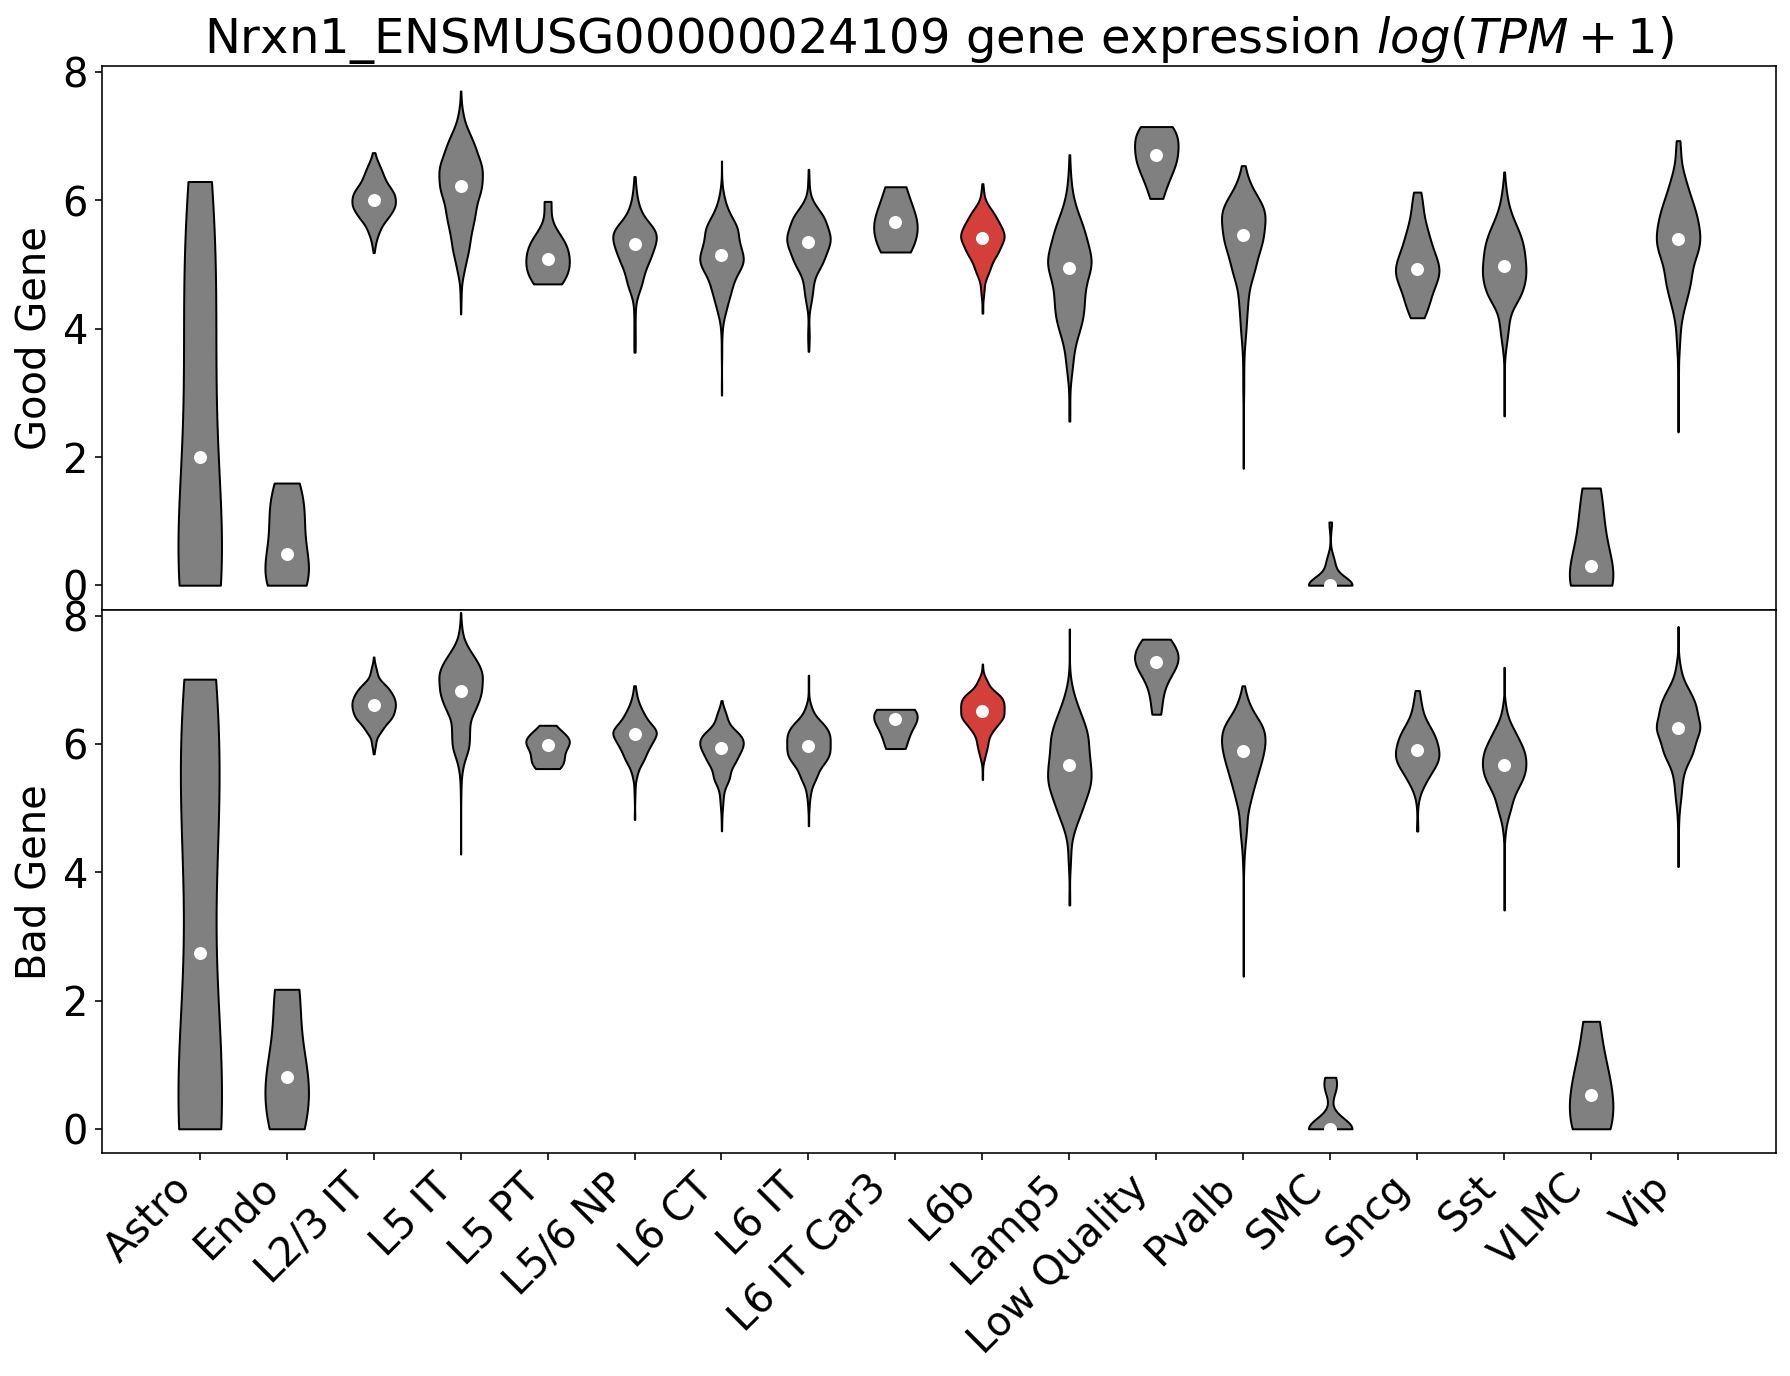

In [15]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene_good.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene_good[gene_good.obs.subclass_label==c][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[0].set_ylabel("Good Gene")


medians = [np.median(i) for i in x]
ax[0].set_xticks(lidx)
ax[0].set_xticklabels(labels, rotation=45, ha="right")
ax[0].set_title("{} gene expression $log(TPM + 1)$".format(specific_gene))


#################### BAD GENE ####################


x = []
for c in unique:
    x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label==c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[1].set_ylabel("Bad Gene")


medians = [np.median(i) for i in x]
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylim(ax[0].get_ylim())




#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [16]:
def yex(ax):
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [17]:
specific_cluster

'L6b'

In [18]:
mtx_good = nd(gene_good.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])
mtx_bad = nd(gene_bad.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])

In [19]:
unique = np.unique(gene_good.obs.subclass_label)

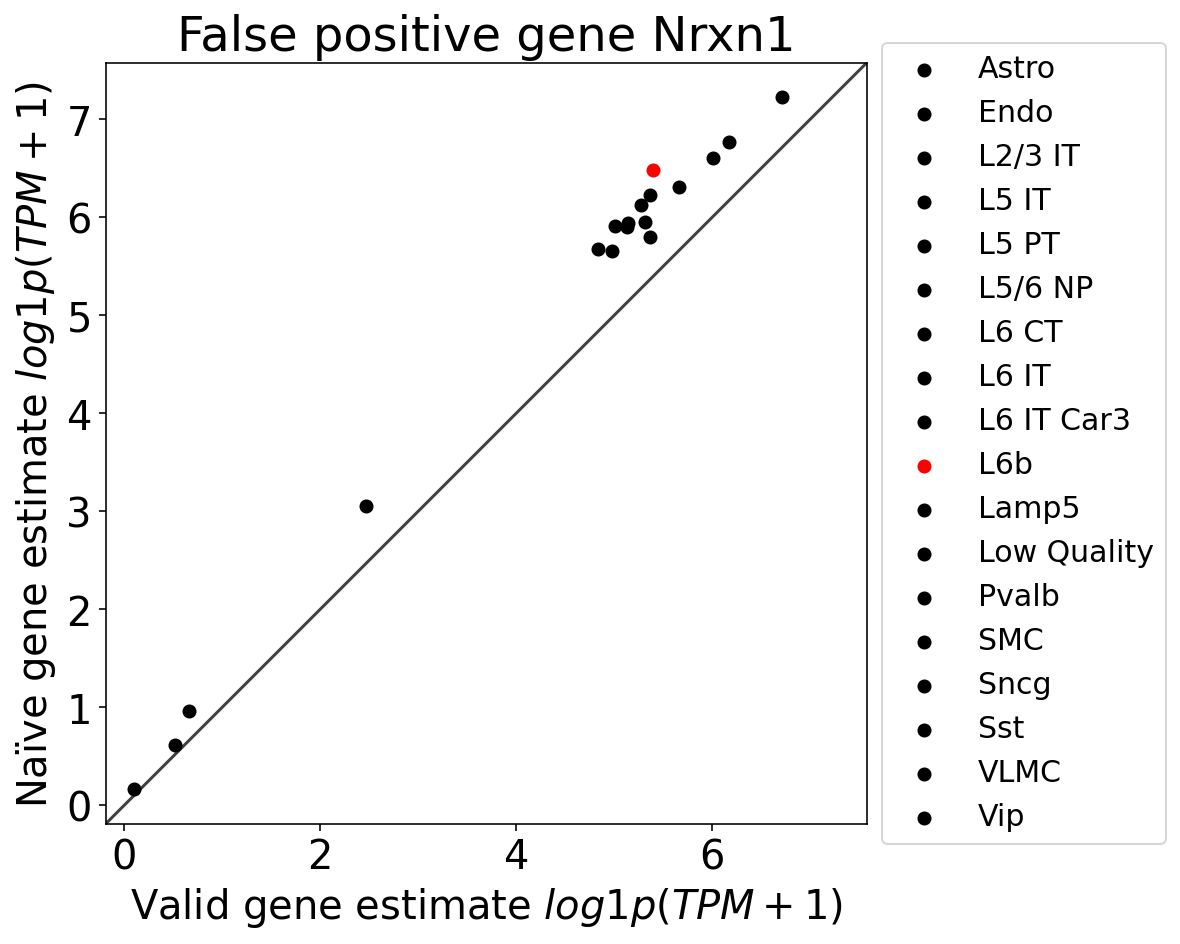

In [20]:
fig, ax = plt.subplots(figsize=(7,7))

ax.set_title("False positive gene {}".format(specific_gene.split("_")[0]))


x = []
y = []

for c in unique:
    x.append(nd(mtx_good[gene_good.obs.subclass_label==c].mean(axis=0)))
    y.append(nd(mtx_bad[gene_bad.obs.subclass_label==c].mean(axis=0)))

for cidx, c in enumerate(unique):
    color="black"
    if c == specific_cluster: color="red"
    ax.scatter(x[cidx], y[cidx], label="{}".format(c), color=color)
ax.set_xlim(0)
yex(ax)
ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5), fontsize=fsize-5)
ax.set_xlabel("Valid gene estimate $log1p(TPM +1)$")
ax.set_ylabel("Naïve gene estimate $log1p(TPM+1)$")

plt.savefig("../../figures/false_positive_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)

plt.show()


# False Negative

In [21]:
good.loc[fn].sort_values("p_raw")

,index,gene_name,p_raw,p_bonferroni


In [22]:
specific_cluster = "L6 CT" 
specific_gene = "Zfp729a_ENSMUSG00000021510"

In [23]:
specific_gene

'Zfp729a_ENSMUSG00000021510'

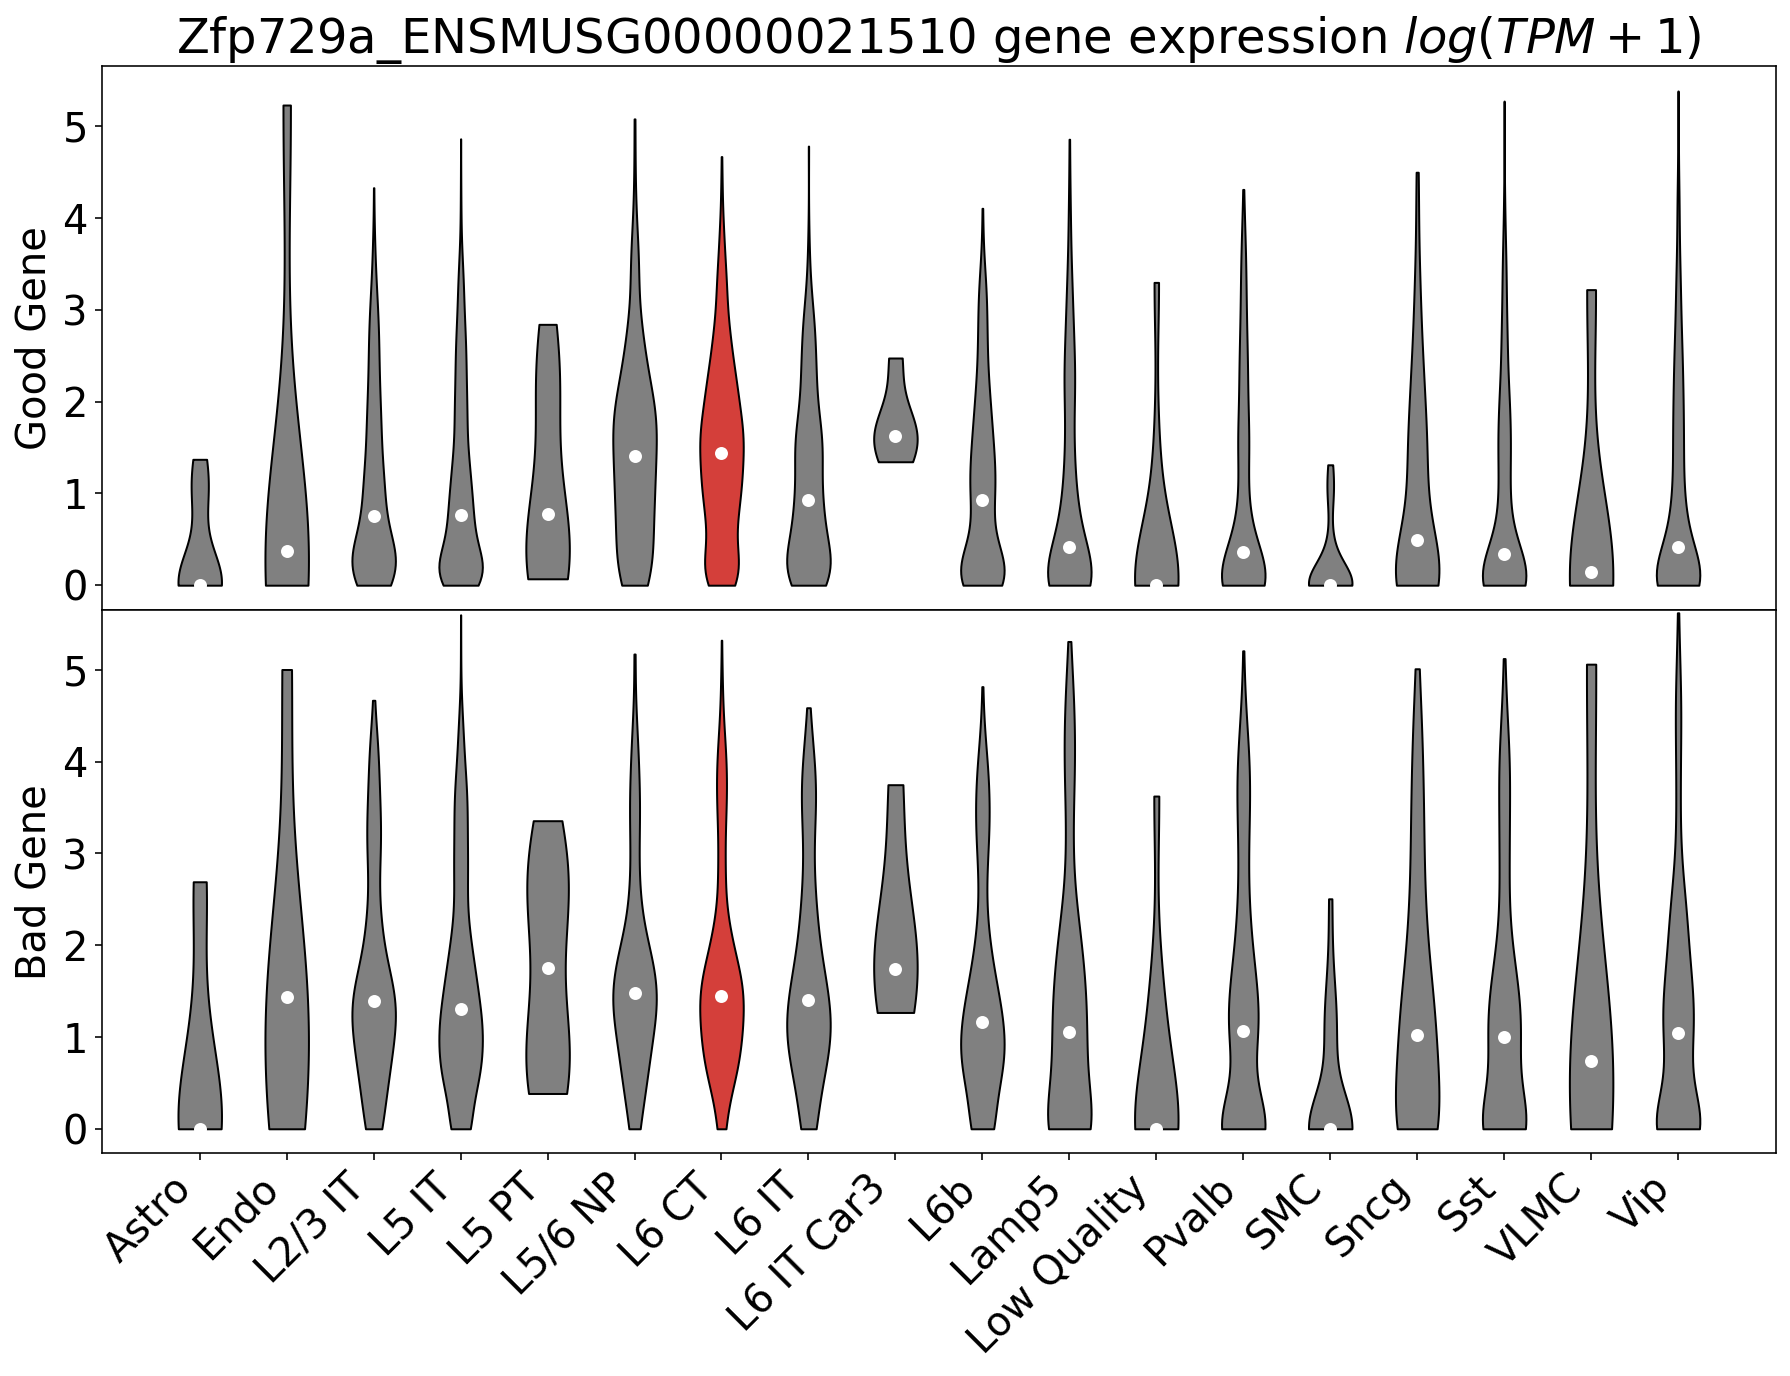

In [24]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene_good.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene_good[gene_good.obs.subclass_label==c][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[0].set_ylabel("Good Gene")


medians = [np.median(i) for i in x]
ax[0].set_xticks(lidx)
ax[0].set_xticklabels(labels, rotation=45, ha="right")
ax[0].set_title("{} gene expression $log(TPM + 1)$".format(specific_gene))


#################### BAD GENE ####################


x = []
for c in unique:
    x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label==c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[1].set_ylabel("Bad Gene")


medians = [np.median(i) for i in x]
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylim(ax[0].get_ylim())




#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [25]:
def yex(ax):
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [26]:
specific_cluster

'L6 CT'

In [27]:
mtx_good = nd(gene_good.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])
mtx_bad = nd(gene_bad.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])

In [28]:
unique = np.unique(gene_good.obs.subclass_label)

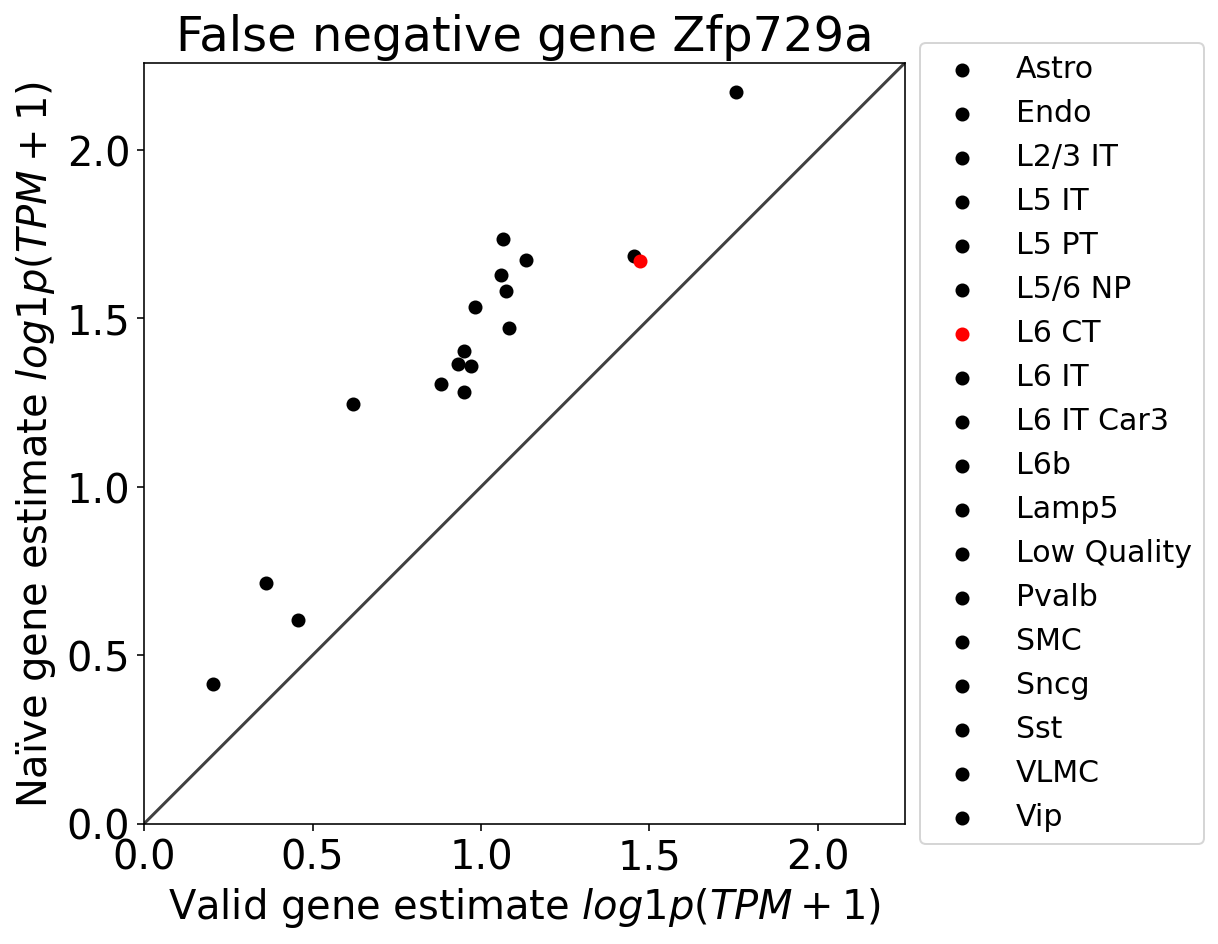

In [29]:
fig, ax = plt.subplots(figsize=(7,7))

ax.set_title("False negative gene {}".format(specific_gene.split("_")[0]))


x = []
y = []

for c in unique:
    x.append(nd(mtx_good[gene_good.obs.subclass_label==c].mean(axis=0)))
    y.append(nd(mtx_bad[gene_bad.obs.subclass_label==c].mean(axis=0)))

for cidx, c in enumerate(unique):
    color="black"
    if c == specific_cluster: color="red"
    ax.scatter(x[cidx], y[cidx], label="{}".format(c), color=color)
ax.set_xlim(0)
yex(ax)
ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5), fontsize=fsize-5)
ax.set_xlabel("Valid gene estimate $log1p(TPM +1)$")
ax.set_ylabel("Naïve gene estimate $log1p(TPM+1)$")


plt.savefig("../../figures/false_negative_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)


plt.show()
